# BEEF example - 3D analyses

In [2]:
from beef import fe
import beef
from beef.newmark import factors as newmark_factors, factors_from_alpha

import numpy as np

from vispy import app, gloo
app.use_app('jupyter_rfb')
import matplotlib.pyplot as plt

In [3]:
# Define sections
# Deck
deck_section_params = dict(
    A=10,
    m=5000,
    I_z=1e-2,
    I_y=1e-2,
    E=210e9,
    J=1e-2,
    poisson=0.3
    )

deck_section = fe.Section(**deck_section_params, name='Deck beam section')

# Tower
tower_section_params = dict(
    A=10,
    m=5000,
    I_z=1e-2,
    I_y=1e-1,
    J=1e-2,
    E=210e9,
    poisson=0.3
    )

tower_section = fe.Section(**tower_section_params, name='Tower beam section')

rayleigh=dict(mass=1e-3, stiffness=1e-3)

In [4]:
# Define geometry and mesh
x = np.linspace(0,100,20)
y = x*1
z = x*0
deck_nodelabels = np.arange(1,21)

node_matrix1 = np.vstack([deck_nodelabels, x, y, z]).T

x1,y1 = x[7], y[7]
x2,y2 = x[12], y[12]
node_matrix2 = np.array([[101, x1, y1, -30],
                         [102, x1, y1, -20],
                         [103, x1, y1, -10],
                         [104, x1, y1, 0],
                         [201, x2, y2, -30],
                         [202, x2, y2, -20],
                         [203, x2, y2, -10],
                         [204, x2, y2, 0]
                        ])

element_matrix1 = np.vstack([deck_nodelabels[:-1], deck_nodelabels[:-1], deck_nodelabels[1:]]).T
element_matrix2 = np.array([[101, 101, 102],
                            [102, 102, 103],
                            [103, 103, 104],
                            [201, 201, 202],
                            [202, 202, 203],
                            [203, 203, 204]]) 

sections1 = [deck_section]*element_matrix1.shape[0]
sections2 = [tower_section]*element_matrix2.shape[0]


In [6]:
# Define constraints and assembly
tie_nodes = [[8, 104], [13, 204]]
constraints_tie = [fe.Constraint([nodes[0]], slave_nodes=[nodes[1]], dofs='all', node_type='beam3d') for nodes in tie_nodes] 
constraints_fix = [fe.Constraint([101, 201], dofs='all', node_type='beam3d')]
constraints_simplysupported = [fe.Constraint([1, 20], dofs=[0,1,2], node_type='beam3d')]

constraints = constraints_tie + constraints_fix + constraints_simplysupported

part1 = fe.Part(node_matrix1, element_matrix1, sections1)
part2 = fe.Part(node_matrix2, element_matrix2, sections2)

assembly = fe.Assembly([part1, part2], constraints=constraints)

RFBOutputContext()


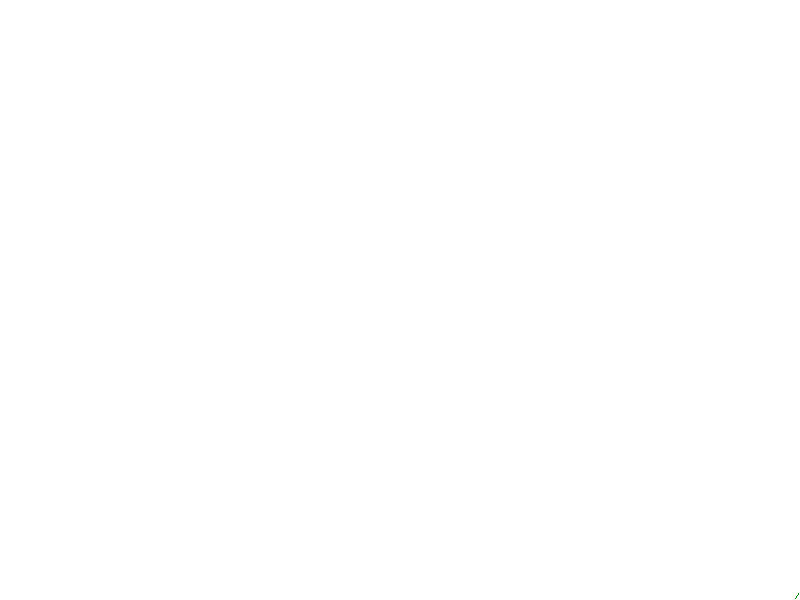

CanvasBackend(css_height='600px', css_width='800px')

In [9]:
sc, __ = assembly.plot(node_labels=True, element_labels=True)
sc

In [10]:
# Create analysis: linear static
forces = [fe.Force(deck_nodelabels, 1, 1000e3)] # 1000 kN downwards on all nodes
analysis = fe.Analysis(assembly, forces=forces)
analysis.run_lin_static()

analysis.eldef.plot(overlay_deformed=True, plot_nodes=True)


Static analysis:   0%|          | 0/2 [00:00<?, ?it/s]

RFBOutputContext()

(<SceneCanvas (jupyter_rfb) at 0x164ed522730>, <ViewBox at 0x164ed41f400>)

[ 1.12091255e+167  1.67708651e+167 -8.50381208e+166]
[ 1.55943272e+167  1.64853064e+167 -4.52496406e+166]
[ 1.65143711e+167  1.42107187e+167 -3.42976723e+166]
[ 1.01073978e+167  1.62769567e+167 -1.08601362e+167]
[ 1.70446990e+167  1.91016041e+167 -6.46864414e+166]
[2.13607134e+167 1.03842900e+167 3.86301531e+165]
[ 2.22193172e+166  1.69425436e+167 -1.46280453e+167]
[1.11717393e+167 3.44290993e+167 1.19529626e+166]
[ 5.70326202e+165  1.50427039e+167 -2.00088317e+167]
[ 2.57171494e+167  1.35236276e+167 -2.06796810e+166]
[ 2.47319202e+167  1.48177571e+167 -2.81134859e+166]
[ 1.08663966e+166  1.58571513e+167 -1.90209536e+167]
[1.26259914e+167 3.28201301e+167 1.40092124e+166]
[-4.95658763e+165  1.53560633e+167 -1.68265572e+167]
[2.00975369e+167 7.48801608e+166 1.28913647e+166]
[ 1.61799937e+167  1.75687953e+167 -5.15813618e+166]
[ 7.90147291e+166  1.49363995e+167 -1.07496406e+167]
[ 1.49301936e+167  1.21311859e+167 -2.58053639e+166]
[ 1.42269121e+167  1.46269849e+167 -3.63140313e+166]
[ 9.3

c:\users\knutankv\git-repos\beef\beef\fe\element.py:92: RuntimeWarning: overflow encountered in square
  return np.sqrt(np.sum(self.get_vec(undeformed=undeformed)**2))
c:\users\knutankv\git-repos\beef\beef\general.py:171: RuntimeWarning: invalid value encountered in divide
  e1 = e1/np.linalg.norm(e1)     # Normalize the direction vectors to become unit vectors
c:\users\knutankv\git-repos\beef\beef\fe\element.py:1058: RuntimeWarning: invalid value encountered in matmul
  self.t = self.get_kd_corot() @ self.v               # new internal forces (element forces) based on the two above
c:\users\knutankv\git-repos\beef\beef\quat.py:96: RuntimeWarning: invalid value encountered in sqrt
  dr0 = np.sqrt(1 - np.dot(dr,dr))


RFBOutputContext()

(<SceneCanvas (jupyter_rfb) at 0x164f10b6df0>, <ViewBox at 0x164f122d070>)

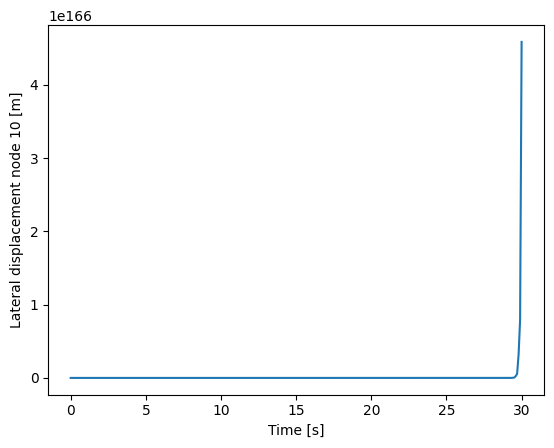

In [14]:
# Create analysis: linear dynamic (with constant load)
forces = [fe.Force(deck_nodelabels, 1, 1000)] # 1000 kN downwards on all nodes
dt = 0.1
tmax = 30

analysis = fe.Analysis(assembly, forces=forces, t0=0, dt=dt, tmax=tmax)
analysis.run_lin_dynamic()

plt.plot(analysis.t, analysis.u[10*6 + 1, :])
plt.xlabel('Time [s]'), plt.ylabel('Lateral displacement node 10 [m]')

# Show deformed plot at time instance
analysis.eldef.deform(analysis.u[:,10])
analysis.eldef.plot(overlay_deformed=True)

In [15]:
# Create analysis: eigenvalue solution
from beef.modal import normalize_phi

analysis = fe.Analysis(assembly)
lambd, phi = analysis.run_eig()

phi = normalize_phi(phi)

mode_ix = 1
scaling = 5.0
analysis.eldef.deform(phi[:,mode_ix]*scaling)
print(f'Mode {mode_ix+1}, f = {np.abs(np.imag(lambd[mode_ix])/2/np.pi):.4f} Hz')
analysis.eldef.plot(overlay_deformed=True)

[ 0.2249975  -0.30890775 -0.41701971]
[ 0.182143   -0.2691571  -0.35673832]
[ 0.07881051 -0.16424783 -0.18551409]
[-0.0484913  -0.0349538   0.04191562]
[-0.17151951  0.07939966  0.22860353]
[-0.22562329  0.14019594  0.31435598]
[-0.16776556  0.08971032  0.26070387]
[-0.02971871 -0.0719886  -0.00602664]
[-0.00232811 -0.03875291  0.04164959]
[-0.0557694  -0.02750612  0.00688232]
[-0.05423018 -0.03121348  0.01070348]
[-0.00652615 -0.03809654  0.040861  ]
[-0.03093074 -0.06455122 -0.00588682]
[-0.13578175  0.07409267  0.22699467]
[-0.19247716  0.1214145   0.26258272]
[-0.14696157  0.0654639   0.19135424]
[-0.0388336  -0.03070534  0.03816566]
[ 0.06522962 -0.13738206 -0.15688326]
[ 0.15202202 -0.22678601 -0.30091535]
[ 0.19048221 -0.26114043 -0.34920589]
[-0. -0. -0.]
[0.00260035 0.05912853 0.00504817]
[ 0.010758   -0.00868002 -0.00391143]
[-0.02971871 -0.0719886  -0.00602664]
[-0. -0. -0.]
[-0.00012235  0.06216702  0.00279096]
[ 0.00722285 -0.00145493 -0.00595736]
[-0.03093074 -0.06455122 

RFBOutputContext()

(<SceneCanvas (jupyter_rfb) at 0x164f0c6f910>, <ViewBox at 0x164f1443cd0>)

[ 2.19024464e+169  3.28304566e+169 -1.66725676e+169]
[ 3.05338404e+169  3.22526811e+169 -8.83430853e+168]
[ 3.23161571e+169  2.77752125e+169 -6.68694736e+168]
[ 1.97111759e+169  3.18999248e+169 -2.13145671e+169]
[ 3.34544077e+169  3.74718137e+169 -1.26008910e+169]
[4.18958089e+169 2.02236762e+169 8.37058432e+167]
[ 4.19306888e+168  3.31979234e+169 -2.90089497e+169]
[2.21717398e+169 6.77798285e+169 2.35965880e+168]
[ 8.55190717e+167  2.93679420e+169 -3.92094720e+169]
[ 4.99559767e+169  2.58735904e+169 -3.85670993e+168]
[ 4.79389139e+169  2.91746883e+169 -5.66991986e+168]
[ 2.48929194e+168  3.06816343e+169 -3.64800425e+169]
[2.40598440e+169 6.26941878e+169 2.70032982e+168]
[-8.51987450e+167  2.94877668e+169 -3.20558032e+169]
[3.85355733e+169 1.44414724e+169 2.40821170e+168]
[ 3.10248242e+169  3.36781573e+169 -9.94550018e+168]
[ 1.52296063e+169  2.86719144e+169 -2.06206527e+169]
[ 2.86930498e+169  2.33333934e+169 -4.97676479e+168]
[ 2.73313005e+169  2.81133678e+169 -6.98897877e+168]
[ 1.7

c:\users\knutankv\git-repos\beef\beef\quat.py:96: RuntimeWarning: invalid value encountered in sqrt
  dr0 = np.sqrt(1 - np.dot(dr,dr))
c:\users\knutankv\git-repos\beef\beef\fe\element.py:92: RuntimeWarning: overflow encountered in square
  return np.sqrt(np.sum(self.get_vec(undeformed=undeformed)**2))
c:\users\knutankv\git-repos\beef\beef\general.py:171: RuntimeWarning: invalid value encountered in divide
  e1 = e1/np.linalg.norm(e1)     # Normalize the direction vectors to become unit vectors
c:\users\knutankv\git-repos\beef\beef\fe\element.py:1058: RuntimeWarning: invalid value encountered in matmul
  self.t = self.get_kd_corot() @ self.v               # new internal forces (element forces) based on the two above


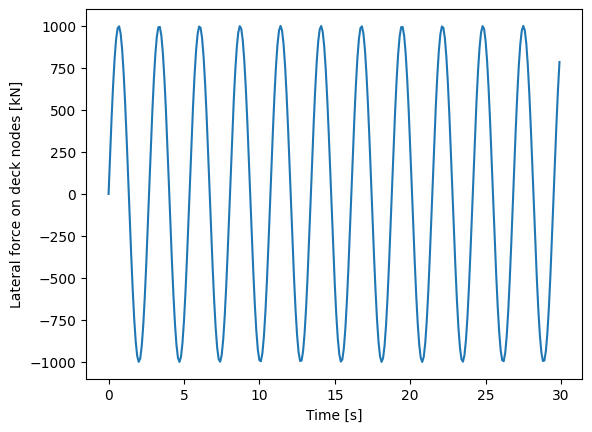

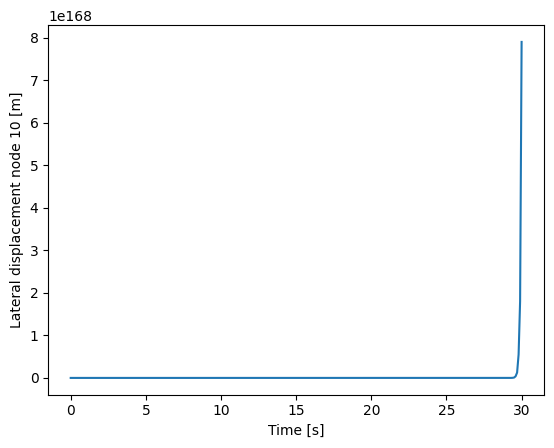

In [16]:
# Create analysis: resonant linear dynamic response
tmax = 30

t_force = np.arange(0, tmax, 0.1)
om_force = 0.3727*(2*np.pi) # 0.36 Hz excitation
force_amplitude = 1000e3*np.sin(t_force*om_force)
plt.plot(t_force, force_amplitude/1e3)
plt.xlabel('Time [s]'), plt.ylabel('Lateral force on deck nodes [kN]')

forces = [fe.Force(deck_nodelabels, 1, force_amplitude, t=t_force)]

dt = 0.1 # for simulation
analysis = fe.Analysis(assembly, forces=forces, t0=0, dt=dt, tmax=tmax, rayleigh=dict(mass=0, stiffness=0))
analysis.run_lin_dynamic()

plt.figure()
plt.plot(analysis.t, analysis.u[10*6 + 1, :])
__,__ = plt.xlabel('Time [s]'), plt.ylabel('Lateral displacement node 10 [m]')